In [40]:
import sys
import time
import datetime
from pathlib import Path
from tqdm import tqdm
import requests

repo_dir = Path('..').resolve()
assert repo_dir.name == 'hicetnunc-dataset', repo_dir
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))

import lib.utils
import lib.iter_tr


stamp_step = 100000
config_hash = 'cd9acbdf4c'
transactions_dir = repo_dir / 'cache' / 'transactions' / config_hash
assert transactions_dir.is_dir()

art_house_contract = 'KT1Hkg5qeNhfwpKW4fXvq7HGZB9z2EnmCCA9'
nft_contract = 'KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton'
comission_wallet = 'tz1UBZUkXpKGhYsP5KtzDNqLLchwF4uHrGjw'


nft_ops = []

for tr in lib.iter_tr.iter_tr(transactions_dir, stamp_step):
    for op in tr['ops']:
        op_hash = op['hash']
        if op['sender'] == nft_contract:
            raise Exception(f'Not expecting nft_contract to send messages: {op_hash}')
        if op['type'] != 'reveal' and op['receiver'] == nft_contract:
            nft_ops.append(op)

In [279]:
class NFTState:
    def __init__(self):
        self.tokens = {}
        self.next_token_id = 152

    def mint(self, pv, op):
        token_id = int(pv['token_id'])
        assert token_id == self.next_token_id
        amount = int(pv['amount'])
        creator = pv['address']
        assert token_id not in self.tokens
        self.tokens[token_id] = {
            'creator': creator,
            'total_amount': amount,
            'token_info_ipfs': pv['token_info']['0@bytes'],
            'created_stamp': lib.utils.iso_date_to_stamp(op['time']),
            'mint_tr_hash': op['hash'],
            'own_counts': {
                creator: amount,
            },
            'transfers': [],
        }
        self.next_token_id += 1

    def transfer(self, pv, op):
        assert len(pv['transfer']) == 1
        trans = pv['transfer'][0]
        sender = trans['from_']
        diff = {}
        for tx in trans['txs']:
            amount = int(tx['amount'])
            if amount == 0:
                continue
            receiver = tx['to_']
            token_id = int(tx['token_id'])
            token_own_counts = self.tokens[token_id]['own_counts']
            assert sender != receiver
            sender_count = self.get_own_count(sender, token_id)
            receiver_count = self.get_own_count(receiver, token_id)
            assert sender_count >= amount
            token_own_counts[sender] = sender_count - amount
            token_own_counts[receiver] = receiver_count + amount
            diff[(sender, token_id)] = self.get_own_count(sender, token_id)
            diff[(receiver, token_id)] = self.get_own_count(receiver, token_id)
            self.tokens[token_id]['transfers'].append({
                'from': sender,
                'to': receiver,
                'count': amount,
                'stamp': lib.utils.iso_date_to_stamp(op['time']),
                'hash': op['hash'],
            })

        return {
            (sender, token_id, count)
            for (sender, token_id), count in diff.items()
        }

    def get_own_count(self, addr, token_id):
        if token_id not in self.tokens:
            raise Exception(f'Token {token_id} not found')
        return self.tokens[token_id]['own_counts'].get(addr, 0)


from collections import Counter


calls_counter = Counter()
status_counter = Counter()
errors_counter = Counter()

nft_state = NFTState()

for op in nft_ops:
    op_hash = op['hash']

    op_status = op['status']
    status_counter[op_status] += 1

    if op_status == 'applied':
        pass

    elif op_status == 'backtracked':
        continue

    elif op_status == 'failed':
        for error in op['errors']:
            assert error['kind'] == 'temporary'
            assert error['id'] in [
                'proto.008-PtEdo2Zk.michelson_v1.runtime_error',
                'proto.008-PtEdo2Zk.gas_exhausted.operation',
            ]
            errors_counter[error['id']] += 1

        continue

    else:
        raise Exception(f'Unknown op status = {op_status}, hash = {op_hash}')

    op_type = op['type']
    if op_type == 'origination':
        assert op is nft_ops[0]
        continue

    assert op_type == 'transaction'

    params = op['parameters']
    call = params['call']
    calls_counter[call] += 1
    value = params['value']

    storage = op['storage']
    assert set(storage.keys()) == {'value'}
    storage_value = storage['value']

    assert set(storage_value.keys()) == {
        'administrator', 'all_tokens',
        'ledger', 'metadata', 'operators',
        'paused', 'token_metadata',
    }
    assert storage_value['administrator'] == art_house_contract
    assert int(storage_value['all_tokens']) >= 0
    assert storage_value['ledger'] == '511'
    assert storage_value['metadata'] == '512'
    assert storage_value['operators'] == '513'
    assert storage_value['token_metadata'] == '514'
    assert storage_value['paused'] == 'false'

    if call == 'set_administrator':
        assert op is nft_ops[1]
        continue

    assert params['entrypoint'] == params['call']

    if call == 'transfer':
        assert op['entrypoint_id'] == 6
        assert params['branch'] == 'RRL'
        assert params['id'] == 6
        assert set(value.keys()) == { 'transfer' }
        assert type(value['transfer']) is list
        assert len(value['transfer']) == 1
        assert set(value['transfer'][0].keys()) == { 'from_', 'txs' }
        assert value['transfer'][0]['from_']
        assert len(value['transfer'][0]['txs']) >= 1

        # if len(value['transfer'][0]['txs']) >= 2:
        #     print(value['transfer'][0]['txs'])

        for tx in value['transfer'][0]['txs']:
            assert set(tx.keys()) == {'amount', 'to_', 'token_id'}

        diff_set = nft_state.transfer(value, op)
        if len(diff_set) == 0:
            assert 'big_map_diff' not in op
            continue

        big_map_diff = op['big_map_diff']
        assert len(big_map_diff) == len(diff_set)
        big_map_diff_set = set()
        for big_map_diff_item in big_map_diff:
            assert big_map_diff_item['action'] == 'update'
            big_map_diff_set.add((
                big_map_diff_item['key']['0@address'],
                int(big_map_diff_item['key']['1@nat']),
                int(big_map_diff_item['value']),
            ))
        assert big_map_diff_set == diff_set

    elif call == 'mint':
        assert op['sender'] == art_house_contract
        assert op['is_internal']
        assert op['entrypoint_id'] == 2
        assert params['branch'] == 'LRL'
        assert params['id'] == 2
        assert set(value.keys()) == { 'address', 'amount', 'token_id', 'token_info' }
        assert int(value['amount'])
        assert int(value['token_id'])
        assert value['address'] == op['creator']
        assert set(value['token_info'].keys()) == {'0@bytes'}
        assert value['token_info']['0@bytes'].startswith('ipfs://')
        assert storage_value['all_tokens'] == str(int(value['token_id']) + 1)

        big_map_diff = op['big_map_diff']
        assert len(big_map_diff) == 2
        assert big_map_diff[0]['key'] == value['token_id']
        assert big_map_diff[0]['action'] == 'update'
        assert big_map_diff[0]['value'] == {
            'token_id': value['token_id'],
            'token_info': value['token_info'],
        }
        assert big_map_diff[1]['key'] == {
            '0@address': value['address'],
            '1@nat': value['token_id'],
        }
        assert big_map_diff[1]['action'] == 'update'
        assert big_map_diff[1]['value'] == value['amount']
        nft_state.mint(value, op)

    else:
        raise Exception(f'Unknown call: {call}')


In [283]:
print(len(nft_ops))
print(calls_counter.most_common())
print(status_counter.most_common())
print(errors_counter.most_common())

32846
[('transfer', 22752), ('mint', 8812), ('set_administrator', 1)]
[('applied', 31566), ('backtracked', 1269), ('failed', 11)]
[('proto.008-PtEdo2Zk.michelson_v1.runtime_error', 11), ('proto.008-PtEdo2Zk.gas_exhausted.operation', 11)]


In [7]:
import importlib
importlib.reload(lib.utils);
importlib.reload(lib.iter_tr);

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

import time

In [15]:
stamps = []

for tr in lib.iter_tr.iter_tr(transactions_dir, stamp_step):
    stamps.append(tr['stamp'])

import time

time.time() - stamps[-1]

99.06009531021118

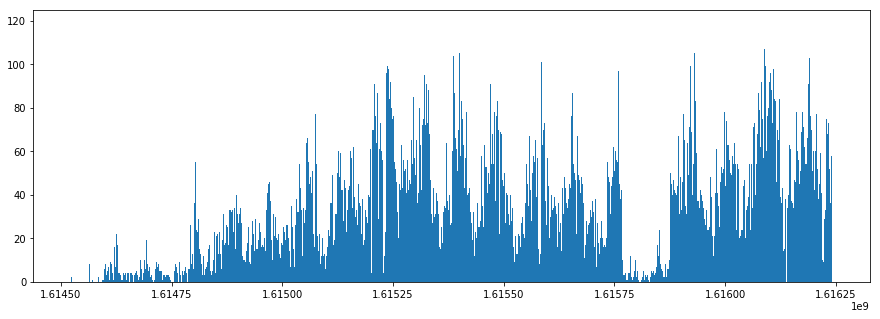

In [16]:
plt.figure(figsize=(15, 5))
plt.hist(stamps, bins=1000);